# **MODELO DE ANÁLISE DAS MÉTRICAS RFV**

***Faremos uma análise RFV, classificando os clientes de um e-commerce em relação a Recência, Frequência e Valor, o que significa:***

***- Recência: Há quanto tempo realizaram suas compras.***

***- Frequência: Com que frequência fazem compras.***

***- Valor: Quanto dinheiro gastam em suas compras.***

***Entendendo o comportamento desses clientes, iremos agrupá-los em clusters e a partir disso poderemos identifcar padrões e características em comum entre os clientes.***

***A partir desses clusters, iremos sugerir a segmentação da base de clientes para que a empresa possa personalizar suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras e visando aumento de lucro.***


# **BIBLIOTECA E BASE DE DADOS**

In [13]:
# Bibliotecas

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Importando o Dataset com tratamento para ser possível a conversão dos tipos de dados

dataset = pd.read_csv('/content/data.csv', encoding = 'unicode_escape')
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
# Informações do Database

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


***Descrição dos dados/colunas:***

***InvoiceNo***: Número único associado a cada fatura/compra.

***StockCode***: Código único associado a cada produto ou item em estoque.

***Description***: Descrição do produto ou item correspondente ao StockCode.

***Quantity***: Quantidade de unidades do produto ou item incluídas em uma compra.

***InvoiceDate***: Data e hora em que a transação foi registrada.

***UnitPrice***: Preço unitário de cada produto ou item.

***CustomerID***: Identificador único associado a cada cliente.

***Country***: País de origem do cliente ou local da transação.

## **PRÉ-PROCESSAMENTO DOS DADOS**

In [16]:
# Verificando a descrição estatística dos dados
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


***Quantidades e Preços Unitários negativos indicam inconsistência, não fazendo sentido. A seguir, filtraremos somente os valores válidos/positivos:***

In [17]:
# Remover linhas onde qualquer uma entre as colunas Quantity e UnitPrice tenha valores <= 0
df = dataset[(dataset['Quantity'] > 0) & (dataset['UnitPrice'] > 0)]

# Verificando o número de linhas e colunas após a remoção
df.shape

(530104, 8)

In [18]:
# Vericiação de quantidade de dados em duplicidade
df.duplicated().sum()

5226

***Não fiz nenhuma alteração quanto às linhas duplicadas, pois entendo que o mesmo cliente pode ter comprado diferentes itens na mesma invoice, por exemplo. Fazendo a exclusão pode haver uma interpretação equivocada.***

In [19]:
# Vericação de dados faltantes
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,132220
Country,0


# **TRATAMENTO DOS DADOS**

In [20]:
# Transformando o tipo de dados da coluna InvoiceDate

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Confirmar o tipo de dados após a conversão
print(df['InvoiceDate'].dtype)

datetime64[ns]


In [21]:
# Transformando o tipo de dados da coluna Quantity

# Converter a coluna Quantity para int
df['Quantity'] = pd.to_numeric(df['Quantity'].astype(int))

# Confirmar o tipo de dados após a conversão
print(df['Quantity'].dtype)

int64


In [22]:
# Transformando o tipo de dados da coluna StockCode

# Converter a coluna StockCode para string
df['StockCode'] = df['StockCode'].astype('string')

# Confirmar o tipo de dados após a conversão
print(df['StockCode'].dtype)

string


In [23]:
# Transformando o tipo de dados da coluna Description

# Converter a coluna Description para string
df['Description'] = df['Description'].astype('string')

# Confirmar o tipo de dados após a conversão
print(df['Description'].dtype)

string


In [24]:
# Transformando o tipo de dados da coluna Country

# Converter a coluna Country para string
df['Country'] = df['Country'].astype('string')

# Confirmar o tipo de dados após a conversão
print(df['Country'].dtype)

string


***Para melhor análise, precisamos encontrar o valor total gasto por compra, criando uma nova coluna onde resulte a quantidade comprada x valor unitário. Encontre a seguir:***

In [25]:
# Encontrando o valor total gasto por compra
df['TotalSpent'] = df['Quantity'] * df['UnitPrice']

In [26]:
# Exibir base de dados com a nova coluna TotalSpent
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalSpe

# **ENCONTRANDO A RECÊNCIA (R)**

***Precisamos encontrar a data de compra mais recente de cada cliente e, para isso, vamos precisar agrupar informações, considerando que um único cliente possui diversas compras distintas. Aplicando a função .max(), conseguiremos determinar a data da última compra de cada cliente.***

In [27]:
# Encontrando a recência
df_recency = (
    df[['InvoiceDate', 'CustomerID']]
    .groupby('CustomerID')['InvoiceDate']
    .agg('max')
    .reset_index()
    )

# Verificando a base de dados criada com recência
df_recency

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00
...,...,...
4333,18280.0,2011-03-07 09:52:00
4334,18281.0,2011-06-12 10:53:00
4335,18282.0,2011-12-02 11:43:00
4336,18283.0,2011-12-06 12:02:00


In [ ]:
***A base de dados criada com recência nos apresenta 4338 clientes e a data da última compra de cada um. A partir daí, vamos calcular a recência em meses. A função abaixo (ref_date)usará a data da última compra registrada no dataset como o ponto de referência e, a partir dessa data, subtrairá a data da última compra de cada cliente, retornando a diferença em meses.
***


***A base de dados criada com recência nos apresenta 4338 clientes e a data da última compra de cada um.
A partir daí, vamos calcular a recência em meses. A função abaixo (ref_date) usará a data da última compra registrada no dataset como o ponto de referência e, a partir dessa data, subtrairá a data da última compra de cada cliente, retornando a diferença em meses.***

In [28]:
# Encontrar a data da última compra registrada no dataset (data de referência)
ref_date = df_recency['InvoiceDate'].max()

# Apresentar a última data encontrada
print(ref_date)

2011-12-09 12:50:00


In [29]:
# Calcular a diferença entre a data de referência e as demais datas registradas para encontrarmos as diferenças em meses
def month_diff(ref_date, datetime_val):
    return 12 * (ref_date.year - datetime_val.year) + (ref_date.month-datetime_val.month)

# Aplicar a função month_diff a cada linha da coluna "InvoiceDate" para criar uma nova coluna com a recência em meses
df_recency['Recency'] = df_recency['InvoiceDate'].apply(lambda datetime_val: month_diff(ref_date, datetime_val))

# Apresentar os dados de recência em meses
print(df_recency)

      CustomerID         InvoiceDate  Recency
0        12346.0 2011-01-18 10:01:00       11
1        12347.0 2011-12-07 15:52:00        0
2        12348.0 2011-09-25 13:13:00        3
3        12349.0 2011-11-21 09:51:00        1
4        12350.0 2011-02-02 16:01:00       10
...          ...                 ...      ...
4333     18280.0 2011-03-07 09:52:00        9
4334     18281.0 2011-06-12 10:53:00        6
4335     18282.0 2011-12-02 11:43:00        0
4336     18283.0 2011-12-06 12:02:00        0
4337     18287.0 2011-10-28 09:29:00        2

[4338 rows x 3 columns]


In [233]:
# Descrever os dados da base de dados com recência
df_recency.describe()

,CustomerID,InvoiceDate,Recency
count,4338.000000,4338,4338.000000
mean,15300.408022,2011-09-08 11:38:59.045643008,3.222453
min,12346.000000,2010-12-01 09:53:00,0.000000
25%,13813.250000,2011-07-20 19:18:00,1.000000
50%,15299.500000,2011-10-20 10:40:30,2.000000
75%,16778.750000,2011-11-22 11:05:45,5.000000
max,18287.000000,2011-12-09 12:50:00,12.000000
std,1721.808492,NaN,3.284536


# **ANÁLISE DOS DADOS**

<Axes: xlabel='Recency'>

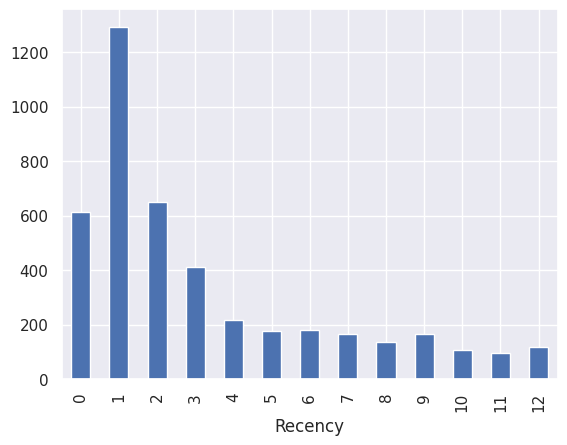

In [234]:
# Análise da recência
df_recency['Recency'].value_counts().sort_index().plot.bar()

***Analisando o gráfico acima, podemos concluir que a maioria dos clientes realizaram sua última compra há 01 mês.***

***Além disso, é possível notar que a maioria dos clientes está há menos de 6 meses sem comprar. Isso indica que a empresa está mantendo um bom relacionamento com os clientes.***

***Porém, há um número expressivo de clientes que estão há mais tempo sem comprar. Vamos analisar os dados para evitar um possível churn desse grupo de clientes. ***

***Agora que sabemos a recência de cada cliente, vamos trabalhar com a coluna CustomerID e Recency, que são os dados que nos interessam.
Em seguida, vamos calcular frequência e valor na mesma tabela para fazermos um JOIN com o dataset_recency.***

In [33]:
# Remover a coluna InvoiceDate
df_recency = df_recency.drop('InvoiceDate', axis=1)

# Apresentar tabela atualizada
print(df_recency)

      CustomerID  Recency
0        12346.0       11
1        12347.0        0
2        12348.0        3
3        12349.0        1
4        12350.0       10
...          ...      ...
4333     18280.0        9
4334     18281.0        6
4335     18282.0        0
4336     18283.0        0
4337     18287.0        2

[4338 rows x 2 columns]


# **ENCONTRANDO A FREQUÊNCIA (F) E O VALOR (V)**

***Para calcular a frequência vamos contar a quantidade de invoices por cliente, uma vez que cada invoice emitida significa uma compra feita (contar a coluna InvoiceNo).***

***Para encontrar o valor vamos calcular a média de gasto (média da coluna TotalSpent criada no início).***

In [34]:
# Encontrar Frequência (contar invoices) e Valor (Find Frequency (count of invoices) and Value (média de gasto e média do valor total por invoice)
df_frequency_value = (df.groupby('CustomerID')[['InvoiceNo', 'TotalSpent']].agg({'InvoiceNo': "count", 'TotalSpent': "mean"}).reset_index())

# Apresentar tabela com F e V
df_frequency_value

,CustomerID,InvoiceNo,TotalSpent
0,12346.0,1,77183.600000
1,12347.0,182,23.681319
2,12348.0,31,57.975484
3,12349.0,73,24.076027
4,12350.0,17,19.670588
...,...,...,...
4333,18280.0,10,18.060000
4334,18281.0,7,11.545714
4335,18282.0,12,14.837500
4336,18283.0,756,2.771005


In [35]:
# Renomear colunas para melhor entendimento
df_frequency_value = df_frequency_value.rename(
            columns={
                "InvoiceNo": "Frequency",
                "TotalSpent": "Value"
            })

# Apresentar tabela com colunas renomeadas
print(df_frequency_value)

      CustomerID  Frequency         Value
0        12346.0          1  77183.600000
1        12347.0        182     23.681319
2        12348.0         31     57.975484
3        12349.0         73     24.076027
4        12350.0         17     19.670588
...          ...        ...           ...
4333     18280.0         10     18.060000
4334     18281.0          7     11.545714
4335     18282.0         12     14.837500
4336     18283.0        756      2.771005
4337     18287.0         70     26.246857

[4338 rows x 3 columns]


In [36]:
# Alterar número de casas decimais da coluna Value para 2 casas
df_frequency_value['Value'] = df_frequency_value['Value'].round(2)

# Apresentar as primeiras linhas da tabela
df_frequency_value.head()

,CustomerID,Frequency,Value
0,12346.0,1,77183.60
1,12347.0,182,23.68
2,12348.0,31,57.98
3,12349.0,73,24.08
4,12350.0,17,19.67


# **RFV**

***Agora temos duas tabelas contendo a coluna CustomerID, que será nossa chave para fazer um join para juntar as informações RFV em uma única tabela.***

In [37]:
# Unir o dataset_recency com o dataset_frequency_value para encontrar a RFV de todos os clientes
df_rfv = df_recency.merge(df_frequency_value, on = 'CustomerID', how='left')
df_rfv = df_rfv.fillna(0)

# Apresentar tabela unificada
print(df_rfv)

      CustomerID  Recency  Frequency     Value
0        12346.0       11          1  77183.60
1        12347.0        0        182     23.68
2        12348.0        3         31     57.98
3        12349.0        1         73     24.08
4        12350.0       10         17     19.67
...          ...      ...        ...       ...
4333     18280.0        9         10     18.06
4334     18281.0        6          7     11.55
4335     18282.0        0         12     14.84
4336     18283.0        0        756      2.77
4337     18287.0        2         70     26.25

[4338 rows x 4 columns]


# **Clusterização: K-means + StandardScaler**

***Escolhi usar o KMeans junto com o StandardScaler para segmentar os clientes porque essa abordagem faz sentido para o tipo de dados que estamos analisando e a necessidade de agrupar os clientes em grupos com características semelhantes.***

***Escolhi o KMeans por ser uma boa opção para essa tarefa, pois ele ajuda a identificar grupos de clientes com comportamentos ou características parecidas.***

***Mas, como o KMeans é sensível à escala dos dados, é importante garantir que todas as variáveis tenham o mesmo peso na análise. Por isso, usei o StandardScaler, que vai normalizar os dados, ajustando todas as variáveis para que contribuam igualmente na formação dos grupos. Com isso, conseguimos identificar os segmentos de clientes com mais precisão, sem que alguma variável maior domine o processo.***

In [38]:
# Aplicar cluster para segmentação dos clientes

# A Frequência e o Valor têm uma grande diferença de escala, por isso vamos tratar o escalonamento para que fiquem mais equilibrados

variable_columns = ['Recency', 'Frequency', 'Value'] #indica as colunas variáveis

stand_data = df_rfv.copy() #cria uma cópia da base de dados

scaler = StandardScaler() #escalona os dados

scaler.fit(df_rfv[variable_columns]) #treina o algoritmo na base de dados original (RFV)

stand_variable = scaler.transform(df_rfv[variable_columns]) # Aplica as transformações

stand_data[variable_columns] = stand_variable # aloca as variáveis transformadas no dataset copiado

***Considerando que a escala está equilibrada, agora vamos criar uma função para treinar o modelo a fim de encontrar o melhor número de clusters (K) com o auxílio do Elbow method:***

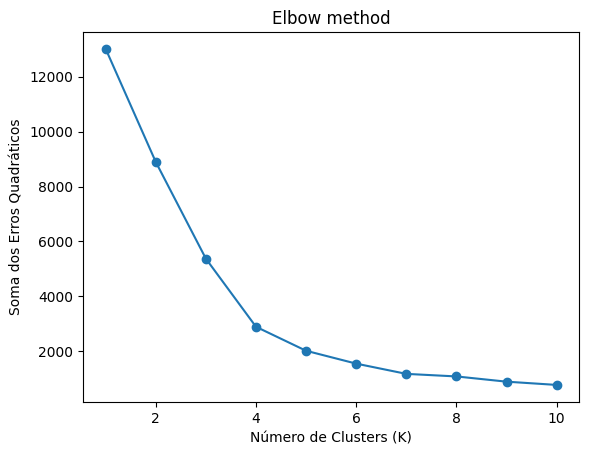

In [39]:
# Lista para armazenar os valores de SSE para diferentes K
sse = []

# Testando diferentes valores de K (de 1 a 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(stand_variable)
    sse.append(kmeans.inertia_)  # .inertia_ retorna a SSE

# Plotando o gráfico de SSE vs K
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Soma dos Erros Quadráticos')
plt.show()

***A partir do método Elbow, identificamos que 4 é o melhor número de clusters a serem considerados, pois a partir dele a soma dos erros quadráticos começa a ser mais suave, diminuindo consideravelmente. Sendo assim, vamos rodar o modelo considerando 4 clusters:***

In [41]:
# Rodar KMeans com 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(stand_data[variable_columns])

# Atribuir rótulos
df_rfv['Cluster'] = kmeans.labels_

# Apresentar as primeiras linhas da base de dados RFV com clusters aplicados
df_rfv.head()

,CustomerID,Recency,Frequency,Value,Cluster
0,12346.0,11,1,77183.60,1
1,12347.0,0,182,23.68,0
2,12348.0,3,31,57.98,0
3,12349.0,1,73,24.08,0
4,12350.0,10,17,19.67,2


# **INTERPRETAÇÃO DOS CLUSTERS**

***Gerei alguns botplox para conseguir analisar as características de cada cluster.
O botplox referente à recência nos indica que:***

***Cluster 0: Lealdade: Com recência baixa, um pouco maior que o Cluster 3, esses clientes demonstram lealdade e frequência nas compras.***

***Cluster 1: Recência Mediana: Esses clientes tendem a retornar em intervalos de tempo mais longos.***

***Cluster 2: Reativação: Este cluster possui a maior média de recência, indicando clientes que precisam de atenção para possível reativação.***

***Cluster 3: Ativos e Engajados: apresenta a menor média de recência, indicando que os clientes desse grupo são valiosos para a empresa, pois tendem a comprar em intervalos curtos de tempo.***

<Axes: xlabel='Cluster', ylabel='Recency'>

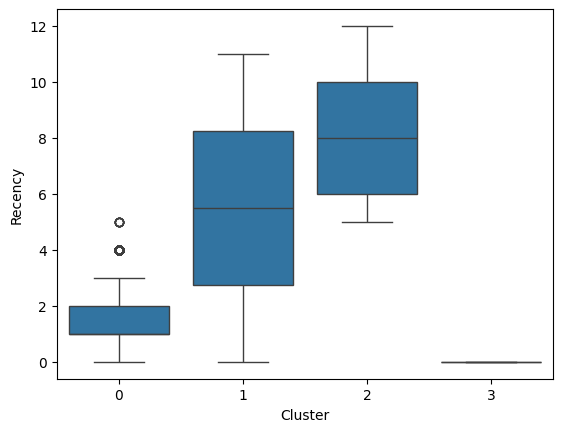

In [46]:
# Investigando o comportamento dos clusters em relação à Recência
sns.boxplot(x='Cluster', y='Recency', data=df_rfv)

***O botplox referente à frequência, abaixo, nos indica que:***

***Cluster 0: Possui a segunda maior frequência, não tão alta, mas indicando que no Cluster 2 existem clientes importantes. É possível adotar estratégias para aumentar a frequência.***

***Cluster 1: Possui alta recência e baixa frequência, indicando que o Cluster 1 possui os clientes menos engajados. É necessário entender os motivos por trás da baixa frequência e alta recência.***

***Cluster 2: Frequência maior que a do Cluster 1, porém menor que a do Cluster 0. Estratégias para incentivar compras mais frequentes incluem ofertas de promoções, mensagens oferecendo produtos novos e a identificação dos itens que os clientes desse cluster tendem a comprar.***

***Cluster 3: Assim como uma baixa recência, o Cluster 3 possui uma alta frequência, indicando que esse cluster contém os clientes mais importantes. É necessário manter esses clientes, pois possivelmente contribuem significativamente para os lucros da empresa.***

<Axes: xlabel='Cluster', ylabel='Frequency'>

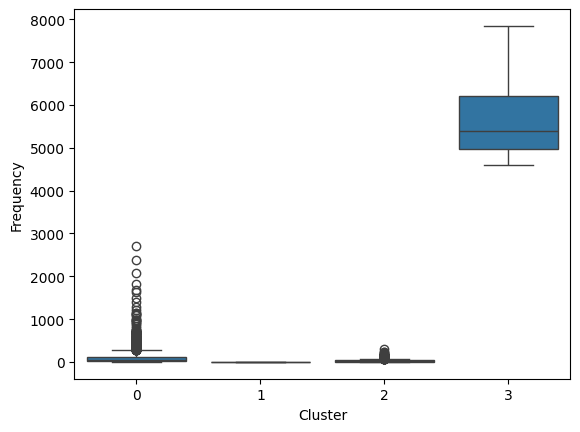

In [47]:
# Investigando o comportamento dos clusters com relação à Frequência
sns.boxplot(x='Cluster', y='Frequency', data=df_rfv)

***Com o botplox referente ao Valor, abaixo, podemos segmentar os clientes da seguinte forma:***

***Cluster 0: Esse cliente é um comprador regular, com interesse contínuo, mas que não comprou recentemente. Ele tende a gastar bem, mas não é o maior consumidor.***

***Cluster 1: Grupo de clientes de atenção, uma vez que compra muito esporadicamente, faz compras de baixo valor, mas sua última compra é bem recente, indicando uma oportunidade de buscar fidelizar esse grupo.***

***Cluster 2: Apesar da maior recência média e menor frequência, este cluster é o que mais gasta.***

***Cluster 3: Recência baixa, frequência alta e valor baixo. Esse perfil pode ser interpretado como um cliente que costumava comprar com frequência, mas o fez com valores menores. Recentemente, ele parou de comprar, o que pode indicar que há algo que o desmotivou ou que ele se afastou da marca por algum motivo.***

<Axes: xlabel='Cluster', ylabel='Value'>

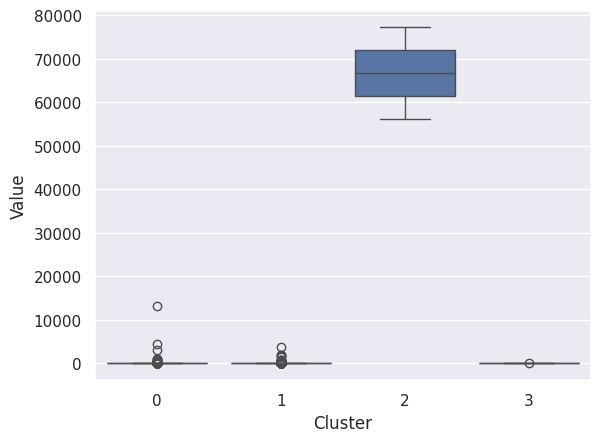

In [249]:
# Investigando o comportamento dos clusters em relação ao Valor
sns.boxplot(x='Cluster', y='Value', data=df_rfv)

***

```
### ***Vamos criar uma nova tabela com as características de cada cluster.***

In [45]:
# Métricas gerais dos clusters

kmeans_metrics = (
    df_rfv.groupby("Cluster")
    [['CustomerID', 'Recency', 'Frequency', 'Value']]
    .agg(
        {
            "CustomerID": "nunique",
            "Recency": "mean",
            "Frequency": "mean",
            "Value": "mean"
    }
    )
    .reset_index()
)

# Exibir por ordem crescente em Recency
kmeans_metrics.sort_values(by='Recency', ascending=True)

,Cluster,CustomerID,Recency,Frequency,Value
3,3,4,0.000000,5807.000000,12.662500
0,0,3190,1.483072,107.242320,32.535671
1,1,2,5.500000,2.000000,66670.550000
2,2,1142,8.088441,28.501751,51.947215


In [251]:
# Renomear coluna CustomerID
kmeans_metrics = kmeans_metrics.rename(columns={"CustomerID": "N_Buyers"}) # CustomerID agora é o número de compradores

# Ordenar por Recência
kmeans_metrics.sort_values(by='Recency', ascending=True)

# Exibir
print(kmeans_metrics)

   Cluster  N_Buyers   Recency    Frequency         Value
0        0       978  8.606339    26.871166     56.604039
1        1      3353  1.655532   103.093349     32.135180
2        2         2  5.500000     2.000000  66670.550000
3        3         5  0.000000  5185.600000     11.030000


In [54]:
# Nomear clusters

name_cluster = [
    'frequentes_economicos',
    'maior_gasto',
    'constantes_moderados',
    'oportunidade_crescimento'
]

#Criar coluna com nomeação
kmeans_metrics['Segmentação'] = name_cluster

# Exibir tabela
kmeans_metrics.head()

,Cluster,CustomerID,Recency,Frequency,Value,Segmentação
0,0,3190,1.483072,107.242320,32.535671,frequentes_economicos
1,1,2,5.500000,2.000000,66670.550000,maior_gasto
2,2,1142,8.088441,28.501751,51.947215,constantes_moderados
3,3,4,0.000000,5807.000000,12.662500,oportunidade_crescimento


# **Possíveis Estratégias de Marketing por Cluster**

A análise de cluster permitiu identificar quatro grupos de clientes com características distintas. As estratégias a seguir podem ser adotadas para melhorar a experiência desses clientes e aumentar a lucratividade da empresa:

**Cluster 0** - Baixa recência, alta frequência, alto valor

Este grupo de clientes provavelmente são clientes leais, com grande potencial de gerar receita, mas que agora estão inativos ou com pouca interação recente. O comportamento deles sugere que há um período em que estavam muito envolvidos com a marca, mas sua última interação foi há algum tempo.

 **Estratégias de marketing:**

- **Reativação de clientes**: Utilizar campanhas de remarketing, descontos especiais ou e-mails personalizados com ofertas exclusivas para recuperar esse grupo.
- **Oferecer benefícios de fidelidade**: Programas de recompensas para encorajar o retorno e reforçar o comportamento de compra frequente.
- **Ações personalizadas**: E-mails com produtos ou serviços que se alinhem ao histórico de compra do cliente, oferecendo uma experiência personalizada para trazê-los de volta.

------------------------------------------------------------

**Cluster 1** - Alta recência, menor frequência, baixo valor

 **Estratégias de marketing:**

- **Incentivar a frequência de compras**: Enviar ofertas de upsell ou cross-sell para incentivá-los a comprar mais frequentemente ou itens de maior valor.
- **Descontos e promoções para estimular compras maiores**: Criar campanhas com descontos para compras em maior volume ou com produtos complementares para aumentar o valor da compra.
- **Fidelização**: Oferecer benefícios para compras recorrentes, como um programa de pontos, para motivá-los a comprar mais vezes e aumentar o valor gasto.

------------------------------------------------------------

**Cluster 2** – Maior recência, baixa frequência, maior valor

 **Estratégias de marketing:**

- **Criar incentivos para aumentar a frequência**: Enviar ofertas de produtos complementares, ou incentivos para que realizem mais compras ao longo do tempo.
- **Ofertas exclusivas e VIP**: Aproveitar seu valor para oferecer ofertas exclusivas, criando uma sensação de pertencimento a um grupo VIP.
- **Lembretes e campanhas personalizadas**: Enviar campanhas mais específicas baseadas em seus interesses e histórico de compras para estimular novas compras, possivelmente com frete grátis ou descontos exclusivos.

------------------------------------------------------------

**Cluster 3** – Menor recência, maior frequência, menor valor

 **Estratégias de marketing:**

- **Recuperação com promoções de baixo valor**: Como eles costumam gastar pouco, oferecer descontos em produtos de baixo custo ou em combos pode atrair esses clientes de volta.
- **Campanhas de reengajamento**: Utilizar e-mails personalizados para relembrá-los da marca e incentivá-los a realizar compras novamente, oferecendo ofertas de produtos que compraram no passado.
- **Promoções baseadas em frequência**: Incentivar o retorno deles por meio de promoções progressivas ou descontos por fidelidade, oferecendo um desconto maior à medida que o número de compras aumenta.

# **RESUMO E CONCLUSÃO**


**Cluster 0**: Clientes valiosos, mas inativos recentemente. Ações de reativação com foco em ofertas personalizadas e programas de fidelidade podem trazê-los de volta.

**Cluster 1**: Clientes ativos recentemente, mas comprando de forma esporádica e com baixo gasto. O objetivo é aumentar a frequência de compras e o valor gasto, usando estratégias de upselling e programas de recompensas.

**Cluster 2**: Clientes de alto valor, mas esporádicos. O foco deve ser em aumentar a frequência de suas compras, oferecendo ofertas exclusivas e personalizadas.

**Cluster 3**: Clientes muito frequentes no passado, mas com gasto baixo e recência baixa. Promoções de baixo valor e ações de reengajamento são fundamentais para trazê-los de volta.

Essas estratégias podem ser ajustadas ao longo do tempo para maximizar o engajamento e aumentar o valor de cada cliente em cada cluster.
